In [32]:
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

# #Top Nikon Eclipse

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [78]:
#!/usr/bin/env python3

import numpy as np

niko = [(25,7),       (30,330),   (35,1400),
        (40,2480),   (45,5000),  (50,7300),
        (55,10000), (60,15400), (65,20000),
        (70,25400), (75,30500), (80,34800),
        (85,41500), (90,46600), (95,51000),
        (100,53100)]
niko      = np.array(niko).astype(float)
niko[:,1] = niko[:,1]/np.max(niko[:,1])

def nikoncalibrator(current_intensity, current_knob, target_intensity):
    '''
    Given  a current intensity and the current position of the knob in the
    top  illuminator  for  the  Nikon  Eclipse  microscope.  This function
    returns  the  position  at which the knob should be set to achieve the
    target  intensity. If the target intensity is outside the range of the
    current estimated range of the knob, an error is raised.

    This is based on data taken by Gabby and David circa 2023.

    Caveat emptor, these are just estimates.

    Parameters
    ----------
    current_intensity : float
        The current intensity of the light source.
    current_knob : float
        The current position of the knob in the top illuminator.
    target_intensity : float
        The target intensity of the light source.
    Returns
    -------
    target_knob : int
        The position of the knob for the top illuminator  to  achieve  the
        target intensity.
    '''
    scaler = np.interp(current_knob, niko[:,0], niko[:,1])
    scaled_niko = niko
    scaled_niko[:,1] = current_intensity / scaler * scaled_niko[:,1]
    max_scaled = int(np.max(scaled_niko[:,1]))
    min_scaled = int(np.min(scaled_niko[:,1]))
    target_knob = int(np.interp(target_intensity, 
                                scaled_niko[:,1], 
                                scaled_niko[:,0]))
    assert target_intensity >= min_scaled, f"Target intensity is too low, minimum is about {min_scaled}. Consider decreasing the overall brightness by other means"
    assert target_intensity <= max_scaled, f"Target intensity is too high, maximum is about {max_scaled}. Consider increasing the overall brightness by other means."
    return target_knob

In [81]:
nikoncalibrator(30000, 50, 20000000)

AssertionError: Target intensity is too high, maximum is about 218219. Consider increasing the overall brightness.

In [36]:
plt.figure()
plt.plot(dummy[:,0],dummy[:,1])
plt.show()

IndexError: invalid index to scalar variable.

<Figure size 640x480 with 0 Axes>

# Intensical Cal 2022

In [12]:
ical = pd.read_excel('./data/LSVN0021-2022.xlsx',sheet_name='DATA',names=['wavelength/nm','I/AU'],skiprows=0,header=None)
ical_old = pd.read_csv('./')

In [16]:
ical_old = np.genfromtxt('./data/intensical_ref.csv',delimiter=',')
old_waves, old_intensities = ical_old[:,0], ical_old[:,1]

In [35]:
waves = ical['wavelength/nm']
intensities = ical['I/AU']
fine_waves = np.linspace(400,1025,6251)
fine_intensities = interp1d(waves, intensities, kind='quadratic')(fine_waves)

In [37]:
import pyperclip

In [45]:
pyperclip.copy('\n'.join(['%.1f, %.6E' % (x,y) for x,y in zip(fine_waves, fine_intensities)]))

In [61]:
%config InlineBackend.figure_format='retina'

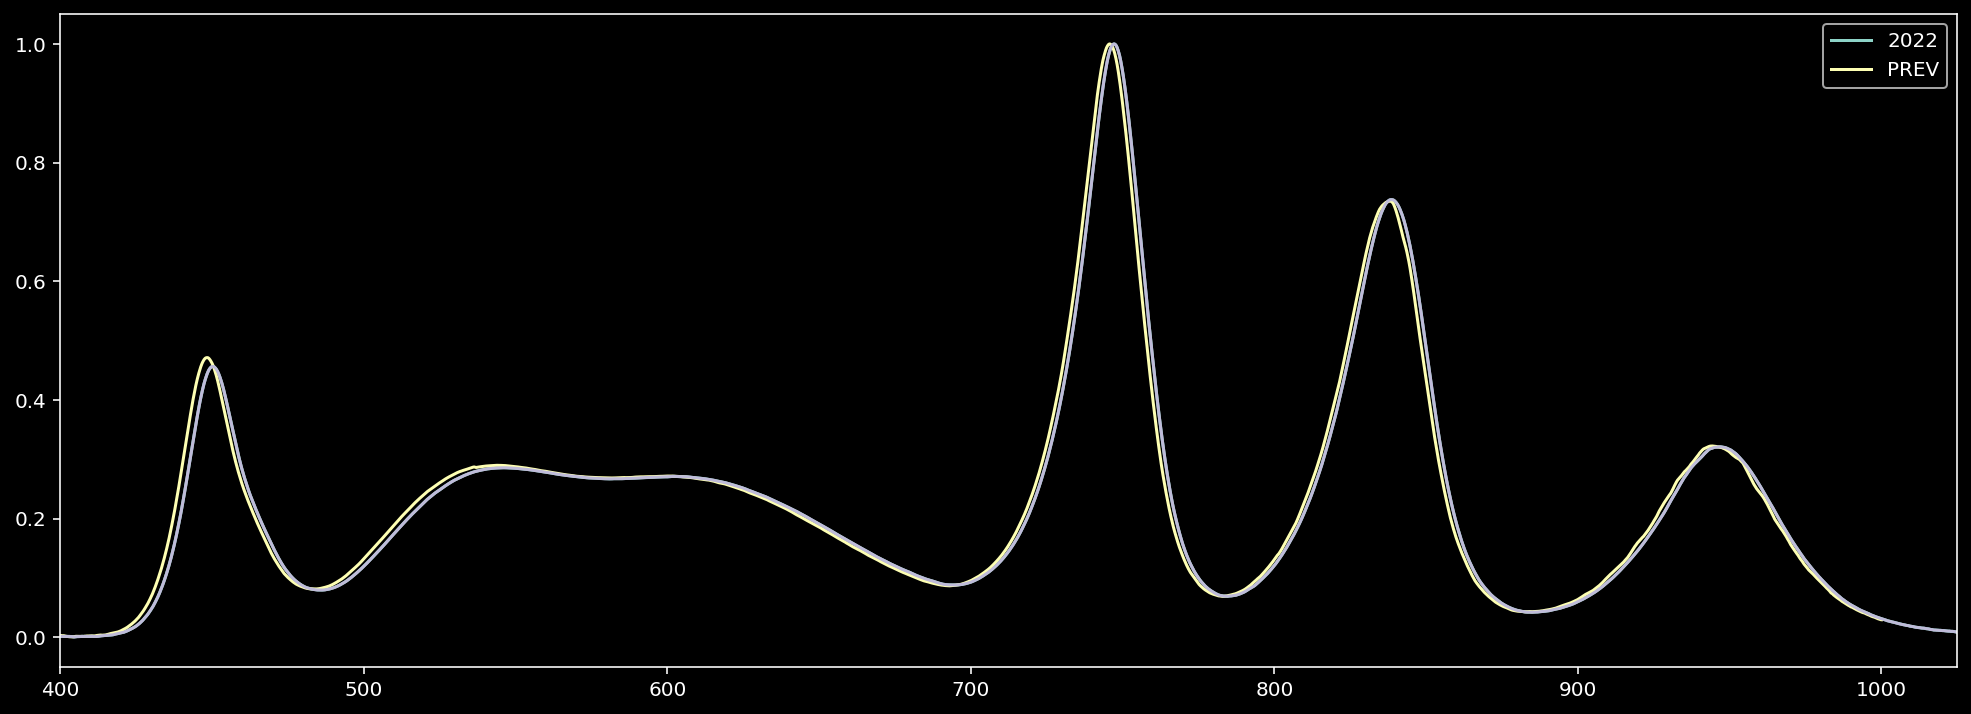

In [62]:
plt.figure(figsize=(17,6))
plt.plot(waves, intensities, label='2022')
plt.plot(old_waves, old_intensities, label='PREV')
plt.plot(fine_waves, fine_intensities)
plt.legend()
plt.xlim(400,1025)
plt.show()

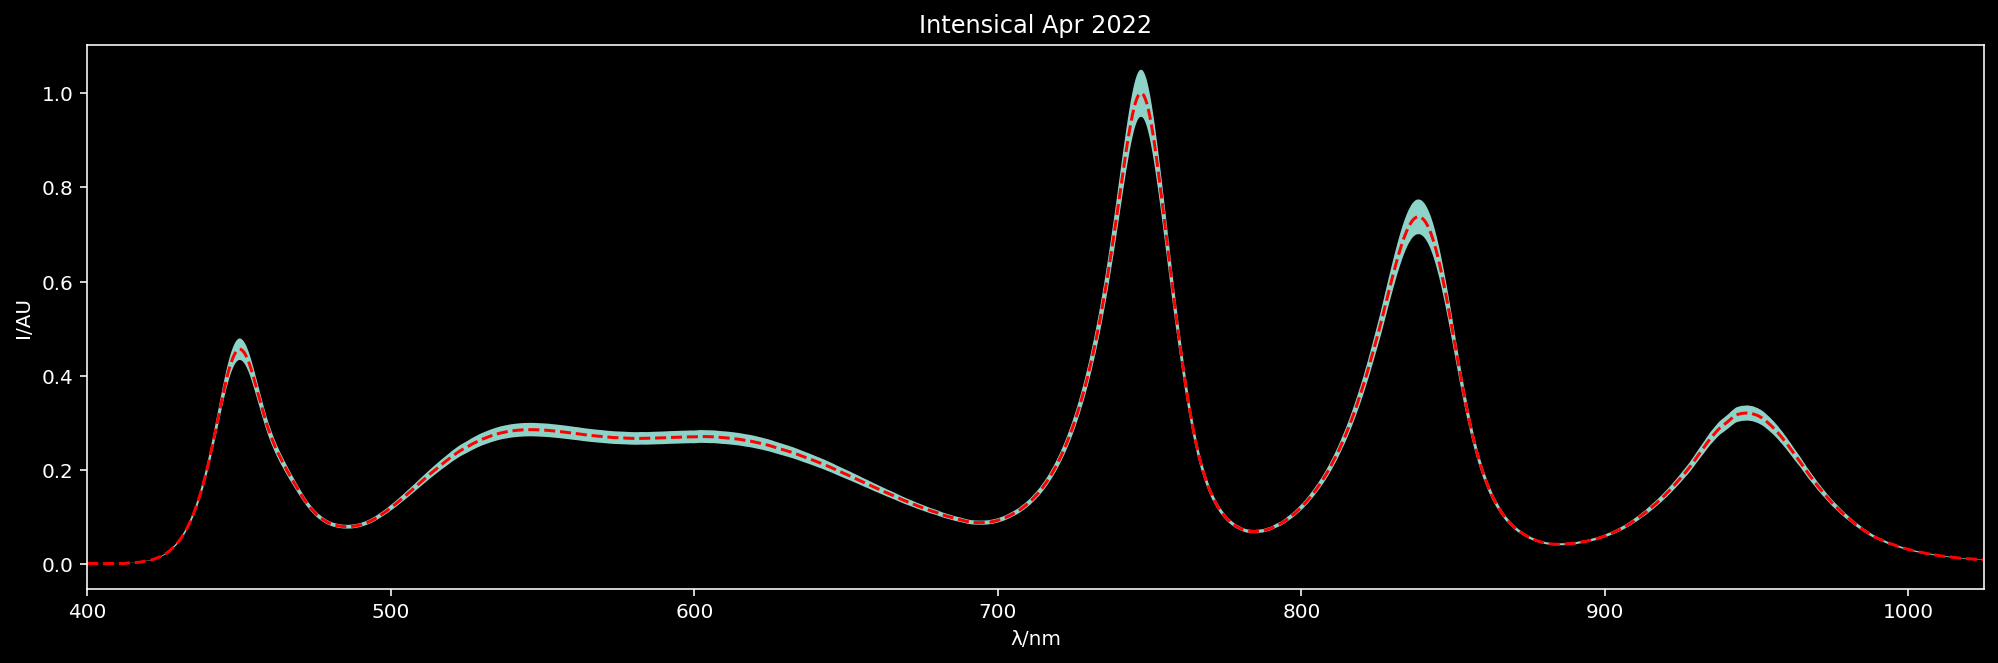

In [63]:
plt.figure(figsize=(17,5))
plt.plot(fine_waves, fine_intensities,'r--')
plt.fill_between(fine_waves, fine_intensities*0.95, fine_intensities*1.05)
plt.xlabel('λ/nm')
plt.ylabel('I/AU')
plt.xlim(400,1025)
plt.title('Intensical Apr 2022')
plt.show()

# Intensical Cal 2022

# Plotting process

In [1]:
import multiprocessing as mp
import time

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

In [2]:
class ProcessPlotter:
    def __init__(self):
        self.x = []
        self.y = []

    def terminate(self):
        plt.close('all')

    def call_back(self):
        while self.pipe.poll():
            command = self.pipe.recv()
            if command is None:
                self.terminate()
                return False
            else:
                self.x.append(command[0])
                self.y.append(command[1])
                self.ax.plot(self.x, self.y, 'ro')
        self.fig.canvas.draw()
        return True

    def __call__(self, pipe):
        print('starting plotter...')

        self.pipe = pipe
        self.fig, self.ax = plt.subplots()
        timer = self.fig.canvas.new_timer(interval=1000)
        timer.add_callback(self.call_back)
        timer.start()

        print('...done')
        plt.show()

In [3]:
class NBPlot:
    def __init__(self):
        self.plot_pipe, plotter_pipe = mp.Pipe()
        self.plotter = ProcessPlotter()
        self.plot_process = mp.Process(
            target=self.plotter, args=(plotter_pipe,), daemon=True)
        self.plot_process.start()

    def plot(self, finished=False):
        send = self.plot_pipe.send
        if finished:
            send(None)
        else:
            data = np.random.random(2)
            send(data)




In [6]:
pl = NBPlot()
for ii in range(10):
    pl.plot()
    time.sleep(0.5)
pl.plot(finished=True)

BrokenPipeError: [Errno 32] Broken pipe

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import multiprocessing
#multiprocessing.freeze_support() # <- may be required on windows

def plot(datax, datay, name):
    x = datax
    y = datay**2
    plt.scatter(x, y, label=name)
    plt.legend()
    plt.show()

def multiP():
    for i in range(2):
        p = multiprocessing.Process(target=plot, args=(i, i, i))
        p.start()

if __name__ == "__main__": 
    input('Value: ') 
    multiP()

# Adding resolution calculators for SP2300 spectrographs

In [3]:
resolutions_SP2300 = {
    'pixis': {
        '150': [[10,20,25,50,100,150,200,300],
                [1.32,1.32,1.32,1.32,2.11,3.17,4.23,6.34]],
        '300': [[10,20,25,50,100,150,200,300],
                [0.648,0.648,0.648,0.648,1.04,1.56,2.08,3.12]],
    },
    'proem': {
        '150': [[10,20,25,50,100,150,200,300],
                [1.27,1.27,1.27,1.27,2.11,3.17,4.23,6.34]],
        '300': [[10,20,25,50,100,150,200,300],
                [0.623,0.623,0.623,0.623,1.039,1.56,2.08,3.12]],
    },
    'pionir': {
        '150': [[10,20,25,50,100,150,200,300],
                [1.27,1.27,1.27,1.27,2.11,3.17,4.23,6.34]],
        '300': [[10,20,25,50,100,150,200,300],
                [0.623,0.623,0.623,0.623,1.039,1.56,2.08,3.12]],
    },
}

def slit_to_resolution_SP2300(grating, slit_width, camera):
    grating_string = re.sub("[^0-9]", "", str(grating))
    if grating_string not in ['150','300']:
        print("Unavailable grating")
        return None
    camera = camera.lower()
    if 'pixis' in camera:
        camera = 'pixis'
    elif 'proem' in camera:
        camera = 'proem'
    elif 'pionir' in camera:
        camera = 'pionir'
    else:
        print("invalid camera choice")
        return None
    return np.interp(slit_width,resolutions_SP2300[camera][grating_string][0],resolutions_SP2300[camera][grating_string][1])

In [4]:
slit_to_resolution_SP2300('300',20,'pixis')

0.648

In [5]:
from matplotlib import pyplot as plt

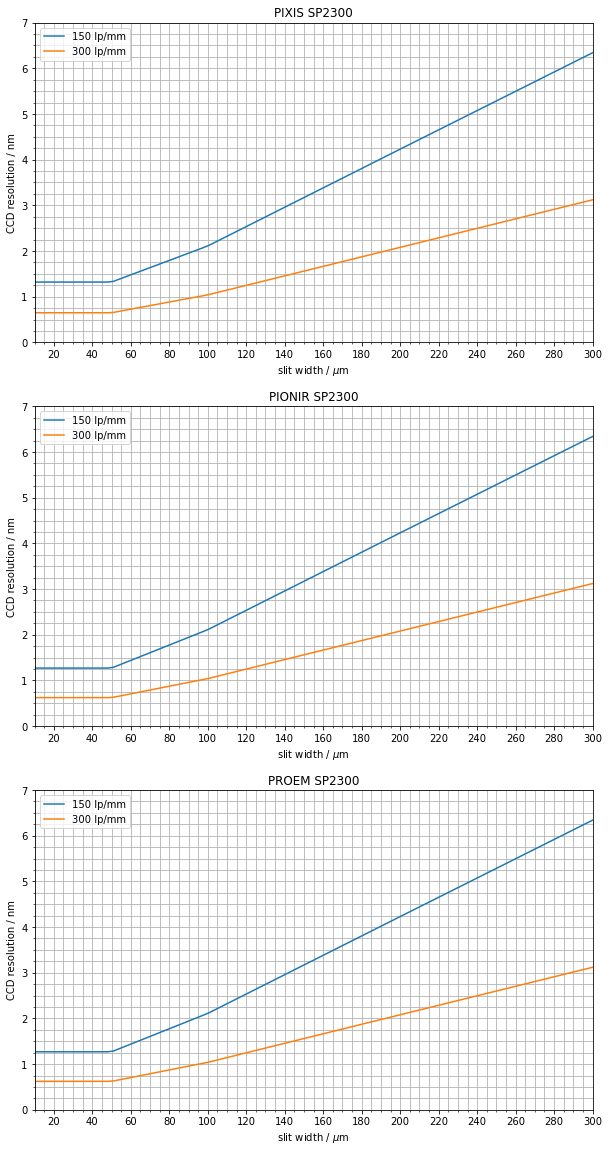

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
slit_widths = np.linspace(10,300,100)
for idx, camera in enumerate('pixis pionir proem'.split(' ')):
    for grating in ['150','300']:
        resols = [slit_to_resolution_SP2300(grating, sw, camera) for sw in slit_widths]
        ax[idx].plot(slit_widths,resols,label='%s lp/mm' % grating)
    major_ticks = np.arange(0, 301, 20)
    minor_ticks = np.arange(0, 301, 5)
    ax[idx].set_xticks(major_ticks)
    ax[idx].set_xticks(minor_ticks, minor=True)
    major_ticks = np.arange(0, 11, 1)
    minor_ticks = np.arange(0, 11, 0.25)
    ax[idx].set_yticks(major_ticks)
    ax[idx].set_yticks(minor_ticks, minor=True)
    ax[idx].legend()
    ax[idx].set_title(camera.upper()+' SP2300')
    ax[idx].set_xlabel('slit width / $\mu$m')
    ax[idx].set_ylabel('CCD resolution / nm')
    ax[idx].set_xlim(10,300)
    ax[idx].grid(True, which = 'both')
    ax[idx].set_ylim(0,7)
plt.show()